# Programming Assignment 4: Action Recognition I
## Introduction
This code trains a C3D network to analyze a video and yields seven estimated 'joint' positions for a subject's head, shoulders (2), elbows (2), and wrists (2). The input dataset has been preprocessed to ensure all videos are in a consistent format (frame width, frame height, number of frames). I chose to use Google Colab for this project as I was expending my laptop's limited GPU resources during testing.

The input dataset is separated into 6000 training video clips and 1000 for testing. As the network is being trained, a validation set is passed through the network and the approximate mean pixel distance error is calculated. This code is written using *tensorflow V1* commands, and the network is built and trained by hand. *A future project will include training this dataset using Keras*

## Importing dependencies

Tensorflow V1 is selected for this project as the code for grading it relies on V1 functions. Numpy is imported for additional preprocessing of the image frames and other matrix math functions. Finally, pyplot will be used to plot the ratio of images for which the predicted cartesian coordinates are within a certian distance of the groundtruth labels.

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt

tf.__version__



TensorFlow 1.x selected.


'1.15.2'

## Loading the Data into Memory

The dataset is small enough to load into memory in a single shot. The image data is loaded into a numpy array using pickle. Running this cell takes a while, so it has been separated from variable initializations as the dataset never changes.

In [ ]:
import pickle

def get_data(path):
    data_file = open(path, 'rb') # open in readBytes mode
    _data, _labels = pickle.load(data_file) # load into np arrays
    data_file.close() # close the file to free up resources
    return _data, _labels # return the two datasets

print("Loading Dataset...")
data_f, labels_f = get_data('/content/drive/My Drive/Colab Notebooks/youtube_train_data.pkl') # call the above function

print("done")


Loading Dataset...
done


## Helper Functions

To make the rest of the code more readable, commonly used procedures are declared in the following cell.

The **plt_errs()** function is used to generate a plot, label the axes, and display it to the user. A steeper curve (that is, a higher ratio of images within a small distance) indicates better overall performance of the network. That is, we want a maximal 'area under the curve'.

The **calc_avg_pxl_dist_err()** function is set up to use a testing set of 60 images; one tenth the size of the training set. It calculates the mean distance between the predicted labels and the ground-truth labels for each of the 7 joint positions. *For images with an error of over 20 px, this will result in a 'negative' ratio as can be seen in the final plot. This needs to be ammended in a future version.*

**next_batch()** simply grabs a certain number of tensors from either the training or testing datasets. *This function should be modified in a future version to randomize the video tensors so that the model is not "over-trained"*

The rest of the functions are responsible for creating weight tensors and convolutional layers used in the network. Refer to the code for more detail on the implementation.

In [ ]:

num_tr_samples = 6000 # I chose to use 6000 frames for training and 1000 for testing
train_data_f = data_f[0:num_tr_samples] # get the first 6000 frames to train
train_labels_f = labels_f[0:num_tr_samples] # get the first 6000 labels
test_data_f = data_f[num_tr_samples:] # the rest go into the testing set
test_labels_f = labels_f[num_tr_samples:]

''' 
FUNCTION plt_errs()

this function takes no arguments. It is called affter the training session is run
to plot the average pixel distance error on the trained model for each joint
position. 
'''
def plt_errs():
    for i in range(7):
        plt.plot(errs[i])
    plt.title('Prediction Accuracy Within 20.0 px')
    plt.legend(['Head', 'R Shoulder', 'L Shoulder', 'R Wrist',
                    'L Wrist', 'R Elbow', 'L Elbow'])
    plt.xlabel('Pixel distance from GT (px * 10)')
    
    plt.ylabel('Ratio of images within distance')
    plt.show()   

'''
FUNCTION calc_avg_pxl_dist_err()

This function takes no arguments. It operates on global variables within the file.
We assume that 100% of predictions are perfect, and then penalize each joint 
position based on the linear pixel distance error. This error is stored in the
matrix errs[][], which keeps track of the 7 positions throughout the testing 
iterations.
'''
errs = [] # initialize an array for the seven joint positions
for i in range(7):# its a 7x200 matrix representing 10*pixel_dist_err
  errs.append([]) # add seven vectors, populate every value with 1
  for k in range(200): # NOTE: avg distance by a factor of 10 (higher resolution when plotting)
    errs[i].append(1) # assume all are 100% accurate, will penalize for incorrect

def calc_avg_pxl_dist_err():
    for i in range(7): # 7 positions
        for j in range(60): # 60 images total
            for k in range(min(int(diffr[j][i]*10),200)):
                errs[i][k] -= 1/(60*5)


'''
function next_batch(tensor x, list y, int start, int end)

grabs a certain number (end - start) of inputs and labels from the training set
and returns the batch. This is to prevent OOM (out of memory) errors when trying
to load a large dataset.

returns a portion of the input from index 'start' to index 'end'
'''
def next_batch(x, y, start, end):
    x_batch = x[start:end,:,:,:]
    y_batch = y[start:end]
    return x_batch, y_batch

'''
function init_weights(tensor shape)

This is a helper function to initialize the weights for a particular convolutional layer.
The shape of the weight matrix is dependent on the model parameters for filter
size and shape. In ourr case, we're using 32 5x5 filters for our convolutional layers.
Uses xavier initialization on weights and biases.

Returns a tensor of variables initialized using the xavier initializer.
The function also creates a variable name 'W' which is scoped to a particular
layer, shown below.
'''
def init_weights(shape):
    return tf.get_variable(
            #dtype=tf.float64,
            name='W',
            shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

'''
function init_bias(tensor shape)

Similar to the function above, returns the bias tensor (vector) for a single
convolutional layer in the network.
'''
def init_bias(shape):
    return tf.get_variable(
            #dtype=tf.float64,
            name='b',
            shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

'''
function conv_layer(tensor x, tensor filter_size, int num_filters, int stride, char[] name)

takes the input tensor, x, and applies a convolutional filter of size filter_size
with other hyperparameters for the number of filters to be use, the stride,
and a scopable name for the layer.

Returns a tensor which has been normalized and sent through a non-linearity
( in this case ReLU ) to be fed into the next layer. function should work for
RGB as well as greyscale images. All variables created in this function are 
scoped to the name provided for the layer. (they should be unique when constructing
the graph - though i think tf will resolve names by appending '_')
'''
def conv_layer(input, fx, fy, num_filters, stride,padding, name):
    with tf.variable_scope(name):
        num_in_channels = input.get_shape().as_list()[-1]
        shape = [fx, fy, num_in_channels, num_filters]
        W = init_weights(shape=shape) # initialize the weights
        b = init_bias(shape=[num_filters]) # initialize the biases
        layer = tf.nn.conv2d( # use the conv2d function from tensorflow to build this layer
                input=input,
                filter=W,
                strides=[1, stride, stride, 1],
                padding=padding,
                )
        layer += b # add in the biases!
        return tf.nn.relu(layer) # send through non-linearity and return
'''
function max_pool(tensor x, tensor ksize, tensor stride, char[] name)

computes the max-pooling layer of a tensor x with kernal ksize and stride stride
used after the convolutional layer to pool its outputs

returns a reduced set (by maximum) of the input. helps to reduce computation space
for the model.
'''
def max_pool(input, ksize, stride, name):
    return tf.nn.max_pool(input, # tensorflow provides a max pooling function, see docs
                          ksize=[1,ksize,ksize,1], # kernal size (flat)
                          strides=[1,stride,stride,1], # strides (also flat)
                          name=name,
                          padding="SAME")



print("done.")

done.


## Constructing the Network

Finally, we have enough in place to start building the 3D-CNN-LSTM network. First, placeholders are created for the input tensors so that we can feed in batches of varying sizes. Then, hyperparameters are declared specifying the number of LSTM cells and input batch size. *The network can be improved by defining variables to make the network architecture more easily varied. In this initial attempt, however, everything was hard-coded.*

In [ ]:
tf.reset_default_graph()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # TENSORFLOW GRAPH
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# input tensor placeholders
input_frames = tf.placeholder( dtype=tf.uint8, shape=[None, 10, 64, 64, 3], name='input_frames')

input_lbls = tf.placeholder(dtype=tf.float32, shape=[None, 10, 7, 2], name='input_lbl')

eta = tf.placeholder(tf.float64, name='lrate')

is_training = True # used for normalization functinos

num_units = 128 # number of lstm units to use
seq_length = 10 # will not change for our project
batch_size = 100 # Caution: large batch sizes will crash computers without large memory

inputs = tf.cast(input_frames, dtype=tf.float32)
outputs = []


''' 
DATA NORMALIZATION BY MINI-BATCH

use tf.batch_normalization to normalize the input tensor values to between
0 and 1. The tf.layers version of this function is a high-level wrapper which
takes care of calculating the running mean and varience in the data. Therefore, 
these portions of the normalization procedure are abstracted. 
'''
inputs = tf.reshape(inputs,shape=[-1,32,32,3])
l1 = tf.layers.batch_normalization(inputs, training=is_training)

'''
CNN SUMMARY:
layer       |   kernel  | Stride  Num.Filters | Padding |    output tensor    |
------------+-----------+---------------------+---------+---------------------|
input_frames|           |                     |         | <?, 10, 32, 32, 3>  |
inputs      |           |                     |         |     <?, 32, 32, 3>  |
conv1       | < 4, 4 >  |     64              |   None  |     <?, 32, 32, 64> |
pool1       | < 2, 1 >  |     --              |   None  |     <?, 32, 32, 64> |
conv2       | < 8, 8 >  |     64              |   None  |     <?, 16, 16, 32> | 
pool2       | < 2, 2 >  |     --              |   None  |     <?,  8,  8, 32> | 
conv3       | < 8, 8 >  |     64              |   None  |     <?,  1,  1, 32> | 
pool3       | < 2, 1 >  |     --              |  Valid  |     <?,  1,  1, 32> |
------------------------------------------------------------------------------|
'''

#print(inputs)
conv1 = conv_layer(input=l1, fx=4, fy=4 , num_filters=64, stride=1, padding="SAME", name='conv1') # create first convolutional
print(conv1)
pool1 = max_pool(input=conv1, ksize=2, stride=1, name='pool1') # max pool conv1
print(pool1)
conv2 = conv_layer(input=pool1, fx=8, fy=8 , num_filters=32, stride=2,padding="SAME", name='conv2') # create second convolutional
print(conv2)
pool2 = max_pool(input=conv2, ksize=2, stride=2, name='pool2') # max pool conv2
print(pool2)
conv3 = conv_layer(input=pool2, fx=8, fy=8, num_filters=32, stride=2, padding="VALID", name='conv3') # create third convolutional
print(conv3)
pool3 = max_pool(input=conv3, ksize=2,  stride=1, name='pool3') # max pool conv3
print(pool3)

# 2d tensor, (seqlen*batchsize,x)
# reshape (batch_size,10,x)

f = tf.reshape(pool3, [-1,10,num_units]) # must reshape the output tensor from conv net
#print(f)


#%%
# define the RNN 
# parameters are defined above 
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units,name="lstmcell")
h_val, _ = tf.nn.dynamic_rnn(lstm_cell, f, dtype=tf.float32)

# print("hval:", h_val)
#%%

ws = 14   
# collection of all the final output
final_output = tf.zeros(shape=[batch_size, 0, 7, 2]) 

with tf.variable_scope('outp', reuse=tf.AUTO_REUSE): # to make the weights for each image
    for i in np.arange(seq_length):     #  independent, needed to name the variables
        w_fc = tf.get_variable(name="Wfc" + str(i), # separately (maybe I could just not name them? )
                       shape=[num_units, ws], # points would be the same across images otherwise.
                       initializer=tf.initializers.truncated_normal(mean=1,stddev=1))
        b_fc = tf.get_variable(name="BFC"+ str(i),
                       shape=[ws],
                       initializer=tf.initializers.truncated_normal(mean=1,stddev=1))
        temp = tf.reshape(h_val[:, i, :], [batch_size, num_units])        
        output = tf.matmul(temp, w_fc) + b_fc        
        output = tf.reshape(output, [-1, 1, 7, 2])        
        final_output = tf.concat([final_output, output], axis=1)

#%%
joint_pos = tf.identity(final_output, name='joint_pos') 
print(joint_pos)
loss = tf.losses.mean_squared_error(input_lbls, joint_pos)
# we can use mean squared error as a loss function for spatial data
diff = input_lbls-joint_pos
#print(diff)
lindist = tf.sqrt(tf.square(diff[:,:,:,0]) + tf.square(diff[:,:,:,1]))
lindif = tf.reshape(lindist, [-1,7])
#print(lindif)


eta = tf.placeholder(tf.float64, name='lrate')
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

optimizer = tf.train.AdamOptimizer( # choose ADAM optimizer - works well
                learning_rate=eta, # with updatable learning rate
                name='AdamOp').minimize(loss) # minimize the loss function

tf.get_collection("validation_nodes") # create a collection called "validation_nodes"
tf.add_to_collection("validation_nodes", input_frames) # add our input to the collection
tf.add_to_collection("validation_nodes", joint_pos) # add our output to the collection
saver = tf.train.Saver()

global_step = 0
lr = 1  # this is the initial learning rate. Since it is being decreased after
# every x number of iterations, we can choose a larger learning rate to start
# such that the loss function converges quicker.

num_tr_iterations = int(len(train_labels_f) / batch_size)



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Tensor("conv1/Relu:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("pool1:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("conv2/Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("pool2:0", shape=(?, 8, 8, 32), dtype=float32)
Tensor("conv3/Relu:0", shape=(?, 1, 1, 32), dtype=float32)
Tensor("pool3:0", shape=(?, 1, 1, 32), dtype=floa

# Training the Network

Finally, the weight tensors are actually initialized and trained. The Adam Optimizer seemed to produce the best results in this project, and converged faster than GD or SGD. In all, 6 batches of 100 video tensors were fed through the network for training. After each epoch, a training set is fed through and these estimates are used to determine the network's accuracy.

...
...
...
...
...
...


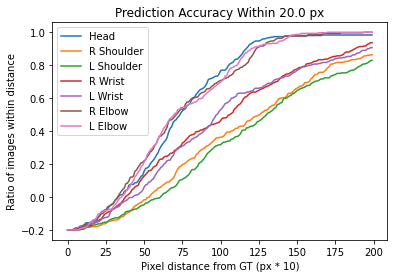

In [ ]:


init = tf.global_variables_initializer()
saver = tf.train.Saver() # needed to save our tensorflow graph
sess = tf.Session() 
sess.run(init) # start the session

#%%
epochs = 6
for epoch in range(epochs): # epochs set at top of document
    global_step += 1 
    ss = global_step*batch_size    
    ee = (global_step + 1)*batch_size
    
    for iteration in range(num_tr_iterations): # = tr size/ epochs
        start = iteration * batch_size  
        end = (iteration + 1) * batch_size
        x_batch, y_batch = next_batch(train_data_f, train_labels_f, start, end) 
        # grab the next batch for training and testing. 
        train_batch = {input_frames: x_batch,
                           input_lbls: y_batch,
                           eta: lr
                           }
        x_t, y_t = next_batch(test_data_f, test_labels_f, ss, ee)
        test_batch = {input_frames: x_t,
                      input_lbls: y_t}
        sess.run(optimizer, feed_dict=train_batch) # train the model using the 
        #print("Doing Something...")
        if (iteration % 20 == 0):
            sys.stdout.write(".")
    is_training = False;
    pred, diffr = sess.run([joint_pos, lindif],feed_dict=test_batch) # get the testing error
    save_path = saver.save(sess, "/content/drive/My Drive/Colab Notebooks/my_model")
    is_training = True;
    #plt_errs(epoch, x_batch, pred) # plot to make sure the predictions make sense
    lr /= 2
    print()
    calc_avg_pxl_dist_err()
plt_errs() # finally, run a session and plot the errors after we have finished
sess.close()

As seen in the plot above, the network was most effective at determining the locations of the head, right elbow and left elbow. These joint positions, in nearly 100 percent of videos, were located to within 15 pixels of the ground-truth location. This probably occurs because the CNN part of the network is able to do feature extraction on these body postions most effectively. Obviously, with a larger dataset, data augmentation, and other preprocessing techniques the performance of the network can be improved. These will be attempted soon.